In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder 

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# preprocessing

### mean imputations 
train['Item_Weight'].fillna((train['Item_Weight'].mean()), inplace=True)
test['Item_Weight'].fillna((test['Item_Weight'].mean()), inplace=True)

### reducing fat content to only two categories 
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace(['low fat','LF'], ['Low Fat','Low Fat']) 
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace(['reg'], ['Regular']) 
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace(['low fat','LF'], ['Low Fat','Low Fat']) 
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace(['reg'], ['Regular'])

## for calculating establishment year
train['Outlet_Establishment_Year'] = 2013 - train['Outlet_Establishment_Year'] 
test['Outlet_Establishment_Year'] = 2013 - test['Outlet_Establishment_Year'] 

### missing values for size
train['Outlet_Size'].fillna('Small',inplace=True)
test['Outlet_Size'].fillna('Small',inplace=True)

### label encoding cate. var.
col = ['Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Fat_Content']
test['Item_Outlet_Sales'] = 0
combi = train.append(test)
number = LabelEncoder()
for i in col:
    combi[i] = number.fit_transform(combi[i].astype('str'))
    combi[i] = combi[i].astype('int')
train = combi[:train.shape[0]]
test = combi[train.shape[0]:]
test.drop('Item_Outlet_Sales',axis=1,inplace=True)

## removing id variables 
training = train.drop(['Outlet_Identifier','Item_Type','Item_Identifier'],axis=1)
testing = test.drop(['Outlet_Identifier','Item_Type','Item_Identifier'],axis=1)
y_train = training['Item_Outlet_Sales']
training.drop('Item_Outlet_Sales',axis=1,inplace=True)

features = training.columns
target = 'Item_Outlet_Sales'

X_train, X_test = training, testing

AttributeError: 'DataFrame' object has no attribute 'append'

# Model exploration

In [ ]:
from xgboost import XGBRegressor
from sklearn.linear_model import BayesianRidge, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
#from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [ ]:
model_factory = [
    RandomForestRegressor(),
    XGBRegressor(nthread=1),
    #MLPRegressor(),
    Ridge(),
    BayesianRidge(),
    ExtraTreesRegressor(),
    ElasticNet(),
    KNeighborsRegressor(),
    GradientBoostingRegressor()
]

for model in model_factory:
    model.seed = 42
    num_folds = 3

    scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error')
    score_description = " %0.2f (+/- %0.2f)" % (np.sqrt(scores.mean()*-1), scores.std() * 2)

    print('{model:25} CV-5 RMSE: {score}'.format(
        model=model.__class__.__name__,
        score=score_description
    ))

RandomForestRegressor     CV-5 RMSE:  1149.67 (+/- 25291.81)
XGBRegressor              CV-5 RMSE:  1166.68 (+/- 25848.00)
Ridge                     CV-5 RMSE:  1206.41 (+/- 54020.12)
BayesianRidge             CV-5 RMSE:  1206.56 (+/- 52695.34)
ExtraTreesRegressor       CV-5 RMSE:  1193.46 (+/- 24126.44)
ElasticNet                CV-5 RMSE:  1259.18 (+/- 89803.16)
KNeighborsRegressor       CV-5 RMSE:  1245.71 (+/- 37275.84)
GradientBoostingRegressor CV-5 RMSE:  1086.27 (+/- 20052.96)


In [ ]:
## normal submission using xgb
model = XGBRegressor()
model.fit(X_train,y_train)
pred = model.predict(X_test)

## saving file
sub = pd.DataFrame(data = pred, columns=['Item_Outlet_Sales'])
sub['Item_Identifier'] = test['Item_Identifier']
sub['Outlet_Identifier'] = test['Outlet_Identifier']
#sub.to_csv('bigmart-xgb.csv', index='False')

cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error', n_jobs=8)

array([-1372897.29618346, -1343142.11548352, -1367379.5208554 ])

Xgb gives us the best results. on submission it gives an rmse of 1152.73

In [ ]:
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, RegressorMixin

class PseudoLabeler(BaseEstimator, RegressorMixin):
    '''
    Sci-kit learn wrapper for creating pseudo-lebeled estimators.
    '''
    
    def __init__(self, model, unlabled_data, features, target, sample_rate=0.2, seed=42):
        '''
        @sample_rate - percent of samples used as pseudo-labelled data
                       from the unlabled dataset
        '''
        assert sample_rate <= 1.0, 'Sample_rate should be between 0.0 and 1.0.'
        
        self.sample_rate = sample_rate
        self.seed = seed
        self.model = model
        self.model.seed = seed
        
        self.unlabled_data = unlabled_data
        self.features = features
        self.target = target
        
    def get_params(self, deep=True):
        return {
            "sample_rate": self.sample_rate,
            "seed": self.seed,
            "model": self.model,
            "unlabled_data": self.unlabled_data,
            "features": self.features,
            "target": self.target
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

        
    def fit(self, X, y):
        '''
        Fit the data using pseudo labeling.
        '''

        augemented_train = self.__create_augmented_train(X, y)
        self.model.fit(
            augemented_train[self.features],
            augemented_train[self.target]
        )
        
        return self


    def __create_augmented_train(self, X, y):
        '''
        Create and return the augmented_train set that consists
        of pseudo-labeled and labeled data.
        '''        
        num_of_samples = int(len(self.unlabled_data) * self.sample_rate)
        
        # Train the model and creat the pseudo-labels
        self.model.fit(X, y)
        pseudo_labels = self.model.predict(self.unlabled_data[self.features])
        
        # Add the pseudo-labels to the test set
        pseudo_data = self.unlabled_data.copy(deep=True)
        pseudo_data[self.target] = pseudo_labels
        
        # Take a subset of the test set with pseudo-labels and append in onto
        # the training set
        sampled_pseudo_data = pseudo_data.sample(n=num_of_samples)
        temp_train = pd.concat([X, y], axis=1)
        augemented_train = pd.concat([sampled_pseudo_data, temp_train])

        return shuffle(augemented_train)
        
    def predict(self, X):
        '''
        Returns the predicted values.
        '''
        return self.model.predict(X)
    
    def get_model_name(self):
        return self.model.__class__.__name__

# Pseudo Labeler

In [ ]:
model = PseudoLabeler(
    XGBRegressor(nthread=1),
    test,
    features,
    target,
    sample_rate = 0.3
)

model.fit(X_train, y_train)
pred = model.predict(X_test)
cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error', n_jobs=8)

array([-1344320.81557252, -1347725.92455491, -1353332.21706081])

In [ ]:
sub = pd.DataFrame(data = pred, columns=['Item_Outlet_Sales'])
sub['Item_Identifier'] = test['Item_Identifier']
sub['Outlet_Identifier'] = test['Outlet_Identifier']
sub.to_csv('pseudo-labelling.csv', index='False')

On submission, it gives a rmse score of 1151.38 which is better than our previous xgb submission.

# Comparing xgboost with xgb with pseudo labelling

In [ ]:
model_factory = [
    XGBRegressor(nthread=1),
    
    PseudoLabeler(
        XGBRegressor(nthread=1),
        test,
        features,
        target,
        sample_rate=0.3
    ),
]

for model in model_factory:
    model.seed = 42
    num_folds = 8
    
    scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error', n_jobs=8)
    score_description = "MSE: %0.4f (+/- %0.4f)" % (np.sqrt(scores.mean()*-1), scores.std() * 2)

    print('{model:25} CV-{num_folds} {score_cv}'.format(
        model=model.__class__.__name__,
        num_folds=num_folds,
        score_cv=score_description
    ))

XGBRegressor              CV-8 MSE: 1156.9265 (+/- 126272.2387)
PseudoLabeler             CV-8 MSE: 1156.6824 (+/- 116614.5211)


# Performance of pseudo-labelling depedendance on sampling rate

In [ ]:
sample_rates = np.linspace(0, 1, 10)

def pseudo_label_wrapper(model):
    return PseudoLabeler(model, test, features, target)

# List of all models to test
model_factory = [
    RandomForestRegressor(n_jobs=1),
    XGBRegressor(),
]

# Apply the PseudoLabeler class to each model
model_factory = map(pseudo_label_wrapper, model_factory)

# Train each model with different sample rates
results = {}
num_folds = 5

for model in model_factory:
    model_name = model.get_model_name()
    print('%s' % model_name)

    results[model_name] = list()
    for sample_rate in sample_rates:
        model.sample_rate = sample_rate
        
        # Calculate the CV-3 R2 score and store it
        scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error', n_jobs=8)
        results[model_name].append(np.sqrt(scores.mean()*-1))

RandomForestRegressor
XGBRegressor


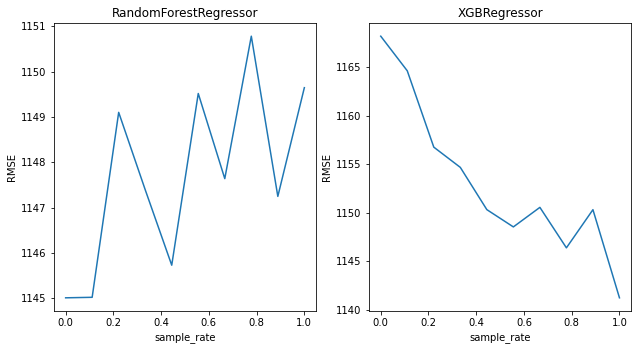

In [ ]:
plt.figure(figsize=(16, 18))

i = 1
for model_name, performance in results.items():    
    plt.subplot(3, 3, i)
    i += 1
    
    plt.plot(sample_rates, performance)
    plt.title(model_name)
    plt.xlabel('sample_rate')
    plt.ylabel('RMSE')
    

plt.show()